# Lineární klasifikace

Úkolem cvičení je naprogramovat lineární klasifikátor, který bude rozpoznávat objekty z datasetu CIFAR-10. **Využijeme k tomu knihovnu pytorch.**

Kromě známých knihoven numpy, matplotlib a torch budeme potřebovat následující:
- torchvision ... rozšiřující pytorch balík pro pytorch obsahující datasety, funkce pro zpracování obrázků a předtrénované modely konvolučních sítí
- tqdm ... vykresluje během výpočtů progress bar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tqdm

## Data

Způsob načítání dat kompletně závisí na způsobu, jakým byla uložena. Zde použijeme populární dataset CIFAR-10, který často slouží jako základní benchmark pro porovnání přínosu nových algoritmů vůči stávajícím. Úkolem je klasifikace obrázků do jedné z 10 tříd.

Balík torchvision podporuje některé znamé datasety, mezi něž patří i CIFAR-10. Nemusíme tedy data stahovat z internetu manuálně, torchvision za nás vše obstará automaticky. Data uložíme do adresáře `./data`. Všimněme si flagu `train=True`, který říká, že se má načíst trénovací množina datasetu CIFAR-10 (soubory `data_batch_*`).

Tenhle komentář změním.

In [2]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
trainset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

Výsledný objekt se chová jako `list`, byť není jeho odvozeninou (subclass). Indexuje tedy prvky od nuly, má definovanou délku skrze `__len__` a podporuje `__getitem__`.

In [3]:
# zavola `__len__`
len(trainset)

50000

In [4]:
# zavola `__getitem__` s parametrem (indexem) 5
trainset[5]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x1EAB58F9C70>, 1)

Jak vidíme, 6. prvek datasetu je *dvojice* sestávající z obrázku a jeho indexu třídy (label, target). Obrázek je defaultně navrácen jako typ `Image` knihovny Pillow (Python Imaging Library, PIL). Pokud je výstupem buňky objekt tohoto typu, jupyter notebook to rozpozná a zobrazí ho jako obrázek. `Image` má totiž definovanou metodu `__html__`, jíž dá notebook přednost před obvyklým `__repr__`.

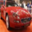

In [5]:
trainset[5][0]

Objekt CIFAR datasetu obsahuje i textový popis tříd ve formě pole (`list`) názvů.

In [6]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
# label 6. prvku
trainset.classes[trainset[5][1]]

'automobile'

Všechny obrázky CIFAR datasetu jsou uloženy v atributu `.train_data`, což je 4D `numpy.ndarray`. První dimenze odpovídá jednotlivým obrázkům, další pak řádkům, sloupcům a kanálům (RGB), tedy $50000 \times 32 \times 32 \times 3$. Hodnoty jsou uloženy jako datový typ `uint8`, tedy v rozsahu 0...255.

In [8]:
type(trainset.data), trainset.data.shape, trainset.data.dtype, trainset.data.min(), trainset.data.max()

(numpy.ndarray, (50000, 32, 32, 3), dtype('uint8'), 0, 255)

Podobně všechny labely jsou uloženy v `.targets`, což je `list` čísel (`int`) o délce počtu obrázků.

In [9]:
type(trainset.targets), len(trainset.targets), type(trainset.targets[0]), min(trainset.targets), max(trainset.targets)

(list, 50000, int, 0, 9)

Pokud chceme obrázků vykreslit více najednou, vhodnější použít matplotlib (pyplot). Pro každou třídu vykreslíme po sloupcích 10 příkladů, abychom viděli, jak data vlastně vypadají.

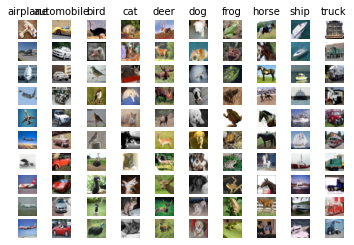

In [10]:
for i, cls in enumerate(trainset.classes):
    # chceme pouze obrazky aktualni tridy a z nich nahodne vybereme 10
    cls_ids = [j for j, y in enumerate(trainset.targets) if y == i]
    draw_ids = np.random.choice(cls_ids, size=10)
    
    # pyplot podobne jako MATLAB nabizi funkci subplot pro vykresleni vice grafu do jednoho okna
    for j, k in enumerate(draw_ids):
        # vykresli 10x10 obrazku, poradi je po radcich, ovsem my budeme vykreslovat po sloupcich,
        # tj. kazdy sloupec bude obsahovat 10 prikladu jedne ze trid
        plt.subplot(10, 10, j * 10 + i + 1)
        
        # vyresli obrazek
        plt.imshow(trainset.data[k])
        
        # nevykresluj popisky os
        plt.axis('off')
        
        # v prvnim radku pridame nazev grafu (obrazku)
        if j == 0:
            plt.title(cls, fontsize=10)
plt.show()

## Testovací/validační data

Testovací data ze souboru `test_batch` načteme stejně jako trénovací, pouze tentokrát nastavíme flag `train` na hodnotu `False`.

In [11]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
testset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

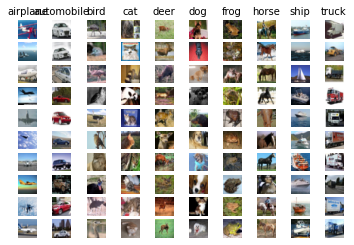

In [12]:
for i, cls in enumerate(testset.classes):
    # chceme pouze obrazky aktualni tridy a z nich nahodne vybereme 10
    cls_ids = [j for j, y in enumerate(testset.targets) if y == i]
    draw_ids = np.random.choice(cls_ids, size=10)
    
    # pyplot podobne jako MATLAB nabizi funkci subplot pro vykresleni vice grafu do jednoho okna
    for j, k in enumerate(draw_ids):
        # vykresli 10x10 obrazku, poradi je po radcich, ovsem my budeme vykreslovat po sloupcich,
        # tj. kazdy sloupec bude obsahovat 10 prikladu jedne ze trid
        plt.subplot(10, 10, j * 10 + i + 1)
        
        # vyresli obrazek
        plt.imshow(testset.data[k])
        
        # nevykresluj popisky os
        plt.axis('off')
        
        # v prvnim radku pridame nazev grafu (obrazku)
        if j == 0:
            plt.title(cls, fontsize=10)
plt.show()

## Matice trénovacích a validačních dat

Jelikož použijeme jednoduchý lineární klasifikátor, data **převedeme do maticové formy**, ve které každý řádek reprezentuje jeden obrázek. Pro lepší numerické chování data navíc z rozsahu `0...255` a typu `uint8` převedeme do rozsahu `0...1` a datového typu s plovoucí řádovou čárkou.

### Validační vs testovací množiny

Testovací sada, která je v případě CIFAR-10 obsažena v souboru `cifar-10-batches-py/test_batch`, by správně neměla být používána pro validaci, tj. volbu modelu a ladění hyperparametrů, ale pouze pro odhad úspěšnosti natrénovaného klasifikátoru na neviděných datech. Pokud použijeme testovací data pro validaci, efektivně tím využíváme informaci v nich obsaženou pro učení modelu. Takto dosažená skóre bychom proto neměli uvádět jako odhad úspěšnosti na neviděných datech, může být totiž příliš optimistický.

In [13]:
# prevedeme na pytorch tensor
X_train = torch.tensor(trainset.data)

# na vychozi datovy typ (float nebo double, lze menit) a do rozsahu 0...1
X_train = X_train.to(torch.get_default_dtype()) / 255.

# reshape na matici s obrazky na radcich
X_train = X_train.reshape(X_train.shape[0], -1)

X_train.dtype, X_train.shape, X_train.min(), X_train.max()

(torch.float32, torch.Size([50000, 3072]), tensor(0.), tensor(1.))

**Labely** trénovacích dat:

In [14]:
y_train = torch.tensor(trainset.targets)
y_train.dtype, y_train.shape, y_train.min(), y_train.max()

(torch.int64, torch.Size([50000]), tensor(0), tensor(9))

Matice **validačních** dat:

In [15]:
# prevedeme na pytorch tensor
X_valid = torch.tensor(testset.data)

# na vychozi datovy typ (float nebo double, lze menit) a do rozsahu 0...1
X_valid = X_valid.to(torch.get_default_dtype()) / 255.

# reshape na matici s obrazky na radcich
X_valid = X_valid.reshape(X_valid.shape[0], -1)

X_valid.dtype, X_valid.shape, X_valid.min(), X_valid.max()

(torch.float32, torch.Size([10000, 3072]), tensor(0.), tensor(1.))

**Labely** validačních dat:

In [16]:
y_valid = torch.tensor(testset.targets)
y_valid.dtype, y_valid.shape, y_train.min(), y_train.max()

(torch.int64, torch.Size([10000]), tensor(0), tensor(9))

## Softmax (logistická regrese)

### Inicializace

Připomeňme, že logistická regrese je jednoduchý lineární klasifikátor s parametry:

- váhová matice $W$
  - rozměr `rozměr_vstupu x počet_tříd`
  - inicializujeme na malé náhodné hodnoty
  - v kódu označíme jako `W_smax` (váhy softmaxu)
- bias vektor $b$
  - rozměr `počet_tříd`
  - inicializujeme na vektor nul
  - v kódu označíme jako `b_smax` (bias softmaxu)

In [17]:
X_train.shape[1]

3072

In [28]:
#################################################################
# ZDE DOPLNIT

W_smax = torch.rand(X_train.shape[1], y_train.max() + 1)/1000

#################################################################

W_smax.dtype, W_smax.shape

(torch.float32, torch.Size([3072, 10]))

In [29]:
#################################################################
# ZDE DOPLNIT

b_smax = torch.zeros(y_train.max() + 1)

#################################################################

b_smax.dtype, b_smax.shape

(torch.float32, torch.Size([10]))

### Trénování metodou online SGD

#### Dopředný průchod
1. Pokud máme na vstupu *jeden* obrázek $x$, vektor lineárního skóre pro jednotlivé třídy je
$$ s := W x + b $$
a tedy $s \in \mathbb{R}^C$, kde $C$ značí celkový počet tříd.

2. Vektor skóre $s$ dále prochází softmaxem. Získáme vektor $p$, ve kterém $i$-tý prvek značí pravděpodobnost, že $x$ patří do třídy $i$.
$$ p := \frac{\exp{s}}{\sum_{c=0}^{C-1}\exp{s_c}} $$
Výsledné $p$ má tedy stejný rozměr jako $s$ a platí $\sum_{c}p_c=1$.

3. Zda a jak moc byla predikce správná určí kriteriální funkce (loss), tzv. cross entropy, která ve speciálním případě klasifikace do jedné z $C$ tříd má tvar
$$L := -\log p_y$$
kde $y\in\{1,\ldots,C\}$ je index třídy, do které obrázek ve skutečnosti patří (label/target obrázku).

##### Regularizace

Regularizace penalizuje příliš velké hodnoty vah $W$. Nejčastěji se setkáme s typem L2, u nějž k výsledné hodnotě lossu přičítáme dodatečný člen
$$\lambda\sum_{ij}w_{ij}^2$$
kde $w_{ij}$ je váha na $i$-tém řádku a $j$-tém sloupci matice $W$ a $\lambda$ je hyperparametr vyjadřující váhu regularizace (v kódu je $\lambda$ označená jako proměnná `l2_decay`).

Pro lepší monitoring hodnoty lossu **regularizaci nepřičítejte**, ale držte ji zvlášť v proměnné `l2_val`.

#### Zpětný průchod
1. Vzorec pro gradient na $c$-tý řádek váhové *matice* je (řádek pro správnou třídu se od ostatních liší)
$$ \frac{\partial L}{\partial w_c} := \left(p_c - \boldsymbol{1}(c=y)\right) x^\top $$

2. Gradient na $c$-tý prvek bias *vektoru* (prvek pro správnou třídu se od ostatních liší)
$$ \frac{\partial L}{\partial b_c} := p_c - \boldsymbol{1}(c=y) $$

##### Regularizace

Pokud používáme regularizaci vah $W$, ještě před updatem parametrů $W$ a $b$ upravíme ${\partial L} / {\partial W}$ gradientem regularizačního členu (ten zvládnete sami). Nezapomeňte na váhu regularizace $\lambda$.

#### Gradient descent update 

1. Update vah $W$
$$ W := W - \gamma \frac{\partial L}{\partial W} $$
kde $\gamma$ je velikost kroku gradient descentu (learning rate)

2. Update biasu $b$
$$ b := b - \gamma \frac{\partial L}{\partial b} $$

### Poznámky

- Popsaný způsob a kostra kódu odpovídá trénování online variantou gradient descentu (stochastic gradient descent, SGD), tzn. update parametrů následuje po každém vstupním vektoru, nikoliv po zpracování všech dat.
- Ve vzorečcích se pracuje s vektorem $x$ jako se sloupcem, ale data v `X_train` jsou po řádcích a matice vah $W$ má rozměr `rozměr_vstupu x počet_tříd`. V kódu proto budou výpočty transponované, tj. $s = x W + b$ a vzorec pro gradient na $c$-tý *řádek* matice $W$ bude ve skutečnosti vzorec na $c$-tý sloupec!
  
  "Proboha proč?", ptáte se? Teorie vychází ze zavedené konvence v lineární algebře, kde jsou vektory uvažovány jako sloupcové a strojové učení tímto způsobem popisuje i většina dopstupné literatury. Pro zachování "kompatibility" materiálů tak postpujejme i zde. Tuto konvenci kdysi dávno převzal jazyk Fortran a v návaznosti na něj i MATLAB, a proto mají tyto jazyky matice uložené po sloupcích. V jazycích jako Python (potažmo v knihovnách numpy a pytorch) jsou však matice tzv. row-major, a tedy daty uloženými typicky po řádcích, a bez transpozice rovnic by se musela transponovat data $x$, což by bylo výpočetně neefektivní.
  
- Většina operací (např. funkce `argmax`) v pytorchi vrací `torch.tensor`, i když je výsledkem jediné reálné číslo. V takovém případě lze obvykle převést na pythonovský built-in typ jednoduše jako např. `int(pytorch_tensor)`.

- Odlaďte trénovací cyklus nejprve pro `num_iters = 1`, pak teprve spusťte na velký počet iterací (např. roven počtu trénovacích obrázků = 1 epocha). Pokaždé, když něco selže, sledujte hodnoty a tvar matic (vektorů) skóre, vah apod. v jednotlivých krocích tak, že si vytvoříte novou buňku a prozkoumáte, co se s nimi děje.

- Hyperparametry $\gamma$ (`learning_rate`) a $\lambda$ (`l2_decay`) nastavte na malé hodnoty $\ll 1$ a optimalizujte tak, abyste dosáhli co nejlepšího skóre na validačních datech. Krok gradient descentu `learning_rate` můžete při opakovaných průchodech daty (epochy) postupně snižovat.

In [33]:
# hyperparametry
learning_rate = 0.001
l2_decay = 0.001
num_iters = 10000

# akumulator
num_correct = 0
loss = 0.
l2_val = 0.

# hlavni trenovaci cyklus
pb = tqdm.tnrange(num_iters)
for n in pb:
    # obrazek vybereme nahodne
    idx = int(torch.randint(X_train.shape[0], (1,)))
    
    # ziskame data
    xn = X_train[idx]
    yn = y_train[idx]
    
    #################################################################
    # ZDE DOPLNIT
    
    # dopredny pruchod: linearni skore, sigmoida a loss
    score = xn@W_smax + b_smax
    prob = torch.exp(score)/torch.sum(torch.exp(score), 0)
    loss += -torch.log(prob[yn])
    l2_val += l2_decay*torch.sum(W_smax**2)
    
    # gradient na skore (clen $(𝑝𝑐−1(𝑐=𝑦))$ ve vzorecku dL/dw_c)
    dscore = prob
    dscore[yn] = dscore[yn] - 1
    
    # gradient na vahy
    dW = dscore*torch.reshape(xn, (xn.shape[0], 1))
    
    # gradient na bias
    db = dscore
    
    # regularizace (volitelna; modifikuje gradient na vahy)
    dW += 0
    
    # update parametru
    W_smax = W_smax - learning_rate*dW
    b_smax = b_smax - learning_rate*db
    
    #################################################################
    
    if score.argmax() == yn:
        num_correct += 1
    
    # prubezny vypis
    if n % 100 == 0:
        pb.set_postfix(loss='{:.3f}'.format(float(loss / (n + 1))), acc='{:.3f}'.format(num_correct / (n + 1)))
print('train accuracy: {}/{} = {:.1f} %'.format(num_correct, n, 100. * num_correct / n))
print(float(loss) / n, float(l2_val) / n)

C:\Users\kanyk\AppData\Local\Temp/ipykernel_17976/315909303.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pb = tqdm.tnrange(num_iters)


  0%|          | 0/10000 [00:00<?, ?it/s]

train accuracy: 2903/9999 = 29.0 %
2.0121682090084008 0.0025491110741323155


### Validace


Natrénovaný klasifikátor ověříme na validační (development) množině. Ideálně bychom měli dosáhnout stejné úspěšnosti jako na trénovací sadě, pravděpodobně tomu tak ale nebude. Proč?

**Postup je jednodušší než v případě trénování:**
1. Dopředný průchod
$$ s := W x + b $$

2. Není třeba počítat pravděpodobnosti. Softmax pouze znormalizuje skóre tak, aby výsledná čísla tvořila rozdělení pravděpodobnosti. Pokud je ve vektoru $s$ max. hodnota na pozici $i$, pak bude $i$-tý prvek max. i ve vektoru $p$. Stačí tedy porovnat index $i$ s labelem obrázku $y$ a pokud se rovnají, je predikce správná, jinak ne. Výsledné skóre pak bude podíl správně klasifikovaných obrázků vůči celkovému počtu.

In [34]:
%%time

num_correct = 0

for n in tqdm.tnrange(X_valid.shape[0]):   
    # ziskame data
    xn = X_valid[n]
    yn = y_valid[n]
    
    #################################################################
    # ZDE DOPLNIT
    
    # dopredny pruchod: linearni skore, sigmoida a loss
    score = xn@W_smax + b_smax
    
    #################################################################
    
    if score.argmax() == yn:
        num_correct += 1

print('val accuracy: {}/{} = {:.1f} %'.format(num_correct, n, 100. * num_correct / n))

<timed exec>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

val accuracy: 3297/9999 = 33.0 %
Wall time: 676 ms


## Weston-Watkins SVM

Jak jsme si ukázali v přednášce, SVM je softmaxu velmi podobné. Z pohledu neuronových sítí se liší pouze způsobem výpočtu lossu - místo cross entropy použijeme hinge loss definovaný jako
$$L = \sum_{c\ne y}\max(0, 1 + s_c - s_y)$$
kde $s$ je vektor lineárních skóre $s=Wx + b$.

Gradient na váhy pak je
$$\frac{\partial L}{\partial w_y} = -\sum_{c\ne y}\boldsymbol{1}(1 + s_c - s_y > 0)x$$
$$\frac{\partial L}{\partial w_{c\ne y}} = \boldsymbol{1}(1 + s_c - s_y > 0)x$$
a pro biasy podobně, pouze bez násobení $x$ (na konci).

### Inicializace

In [43]:
#################################################################
# ZDE DOPLNIT

W_svm = torch.rand(X_train.shape[1], y_train.max() + 1)/1000

#################################################################

W_svm.dtype, W_svm.shape

(torch.float32, torch.Size([3072, 10]))

In [40]:
#################################################################
# ZDE DOPLNIT

b_svm = torch.zeros(y_train.max() + 1)

#################################################################

b_svm.dtype, b_svm.shape

(torch.float32, torch.Size([10]))

### Trénování

### Validace

In [44]:
%%time

# hyperparametry
learning_rate = 0.002
l2_decay = 0.001
num_iters = 10000
# akumulator
num_correct = 0
loss = 0.
l2_val = 0.

# hlavni trenovaci cyklus
pb = tqdm.tnrange(num_iters)
for n in pb:
    # obrazek vybereme nahodne
    idx = int(torch.randint(X_train.shape[0], (1,)))
    
    # ziskame data
    xn = X_train[idx]
    yn = y_train[idx]
    
    #################################################################
    # ZDE DOPLNIT
    
    # dopredny pruchod: linearni skore, sigmoida a loss
    score = xn@W_svm + b_svm
    margin = ((torch.sum(W_svm**2, 0))**2)/2
    loss_tmp = torch.maximum(torch.zeros(score.shape[0]), 1+score-score[yn])
    loss_tmp[yn] = 0
    loss += torch.sum(loss_tmp)
    l2_val += l2_decay*torch.sum(W_smax**2)
    
    # gradient na bias
    db = 1*(1+score-score[yn] > 0)
    db[yn] = -torch.sum(1*(1+score-score[yn] > 0))
    
    # gradient na vahy
    dW = (1*(1+score-score[yn] > 0))*torch.reshape(xn, (xn.shape[0], 1))
    dW[:,yn] = -torch.sum((1*(1+score-score[yn] > 0))*torch.reshape(xn, (xn.shape[0], 1)),1)
    
    # regularizace (modifikuje gradient na vahy)
    dW += 0
    
    # update parametru
    W_svm = W_svm - learning_rate*dW
    b_svm = b_svm - learning_rate*db
    
    #################################################################
    
    if score.argmax() == yn:
        num_correct += 1
    
    # prubezny vypis
    if n % 100 == 0:
        pb.set_postfix(loss='{:.3f}'.format(float(loss / (n + 1))), acc='{:.3f}'.format(num_correct / (n + 1)))

print('train accuracy: {}/{} = {:.1f} %'.format(num_correct, num_iters, 100. * num_correct / num_iters))
print(float(loss) / num_iters, float(l2_val) / num_iters)

<timed exec>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

train accuracy: 2487/10000 = 24.9 %
25.660215625 0.0038311710357666015
Wall time: 12 s


In [45]:
%%time

num_correct = 0

for n in tqdm.tnrange(X_valid.shape[0]):   
    # ziskame data
    xn = X_valid[n]
    yn = y_valid[n]
    
    #################################################################
    # ZDE DOPLNIT
    
    # dopredny pruchod: linearni skore, sigmoida a loss
    score = xn@W_svm + b_svm
    
    #################################################################
    
    if score.argmax() == yn:
        num_correct += 1

print('val accuracy: {}/{} = {:.1f} %'.format(num_correct, X_valid.shape[0], 100. * num_correct / X_valid.shape[0]))

<timed exec>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/10000 [00:00<?, ?it/s]

val accuracy: 3100/10000 = 31.0 %
Wall time: 745 ms
